%%latex
\tableofcontents

In [163]:
# Basic imports
import os
master_dir  = os.getcwd()  # the main working directory
data_dir    = os.path.join(master_dir, "Files")  # sub directory where we save data files
plots_dir   = os.path.join(master_dir, "Plots")  # sub directory where we save plots
import numpy as np
import pandas as pd
import scipy.io
from typing import Callable, Any
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA as skPCA
plt.rcParams['figure.figsize'] = (11, 3)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],  # "Times", "Palatino", "New Century Schoolbook", "Bookman", 
    })
# For preprocessing the images:
from skimage.exposure import rescale_intensity
from sklearn.manifold import TSNE
tsne_size = (8,5)
fs_tsne = 20
fs = 20
fs_ticks_tsne = 12
fs_labels = fs + 2
fs_legend = fs + 4
fs_ticks = fs

Hyperparams for plotting:

# Principal components analysis

In this part of the assignment, we will look at PCA analysis. We will define our own class that implements the PCA algorithm, both fitting the PCA as well as applying its transformation and the inverse transformation.

This code defines a Python class `PCA` that implements Principal Component Analysis (PCA) for dimensionality reduction. The `__init__` method initializes some class attributes: `q` is the number of components to keep or the threshold for explained variance ratio, `n_components` is the actual number of components to keep after fitting the PCA model, `mean` is the mean of the input data `x`, `cumsum` is the cumulative sum of the explained variance ratio, and `projection_matrix` is the projection matrix used for transforming the data. 

The `fit` method fits the PCA model to the input data `x`. First, it computes the mean of the input data and subtracts it from each observation, so that the data is centered at zero. Then, it computes the covariance matrix and performs its eigenvalue decomposition to obtain the eigenvalues and eigenvectors. The eigenvalues and eigenvectors are sorted in descending order of the eigenvalues. The cumulative sum of the sorted eigenvalues is also computed and saved in `cumsum`. The actual number of components to keep is determined either by the integer `q` or by the threshold `q` for explained variance ratio. The projection matrix is the matrix of the first `n_components` eigenvectors, which are also saved in `projection_matrix`. Note that the "projection matrix" hence corresponds to the matrix $E^T$ as defined in the assignment.

The `transform` method transforms the input data `x` into the lower-dimensional space by projecting it onto the `projection_matrix`.

The `inverse_transform` method transforms the data back to the original space by multiplying the data with the transpose of the `projection_matrix`.

In [164]:
class PCA:
    """Class implementing the PCA algorithm"""
    
    def __init__(self, q):
        """Initilize the PCA object.
        Args:
            q (int, float): Number of principal components. If a float between 0 and 1 is given, compute number of components such that 
            ratio of cumulative sum of eigenvalues is at least q. 
        """
        
        self.q = q
        # ^ q parameter: either number of components or percentage of explained variance desired
        self.n_components = 0
        # ^ the number of principal components (either equals q or has to be computed in fit)
        self.mean = None
        # ^ the mean vector of the dataset when given to fit
        self.cumsum = None
        # ^ ratio of the cumulative sum of eigenvalues, also known as explained variance ratio
        self.projection_matrix = None
        # ^ the "projection matrix", what is called E^T in the ANN Assignment
        
    def fit(self, X):
        """Fit PCA according to given dataset X.

        Args:
            X (np.array): Dataset on which we wish to apply PCA.
        """
        
        # For safety, we copy the dataset to work on it here
        x = X.copy()
        
        # Compute mean and center the data
        self.mean = np.mean(x, axis = 1).reshape(-1, 1)
        x -= self.mean 
        # Compute covariance matrix and its EVD
        self.cov = np.cov(x)
        eigenvals, eigenvecs = np.linalg.eig(self.cov)
        # Now, eigenvecs are columns, so transpose to get eigenvecs as rows
        eigenvecs = np.transpose(eigenvecs)
        # Sort, in descending order, eigenvalues and their vecs
        sort_ind = np.argsort(eigenvals)[::-1]
        self.eigenvals = eigenvals[sort_ind]
        self.eigenvecs = eigenvecs[sort_ind]
        # Save the cumulative sum (ratio) to get explained variance ratio
        self.cumsum = np.cumsum(self.eigenvals)/np.sum(self.eigenvals)
        # Check how to compute number of components (depends on q being int or float):
        if isinstance(self.q, int):
            # Parameter q given was an integer: this is number of components
            self.n_components = self.q
        else:
            # Choose number of components based on threshold by explained variance ratio:
            self.n_components = np.sum(np.where(self.cumsum < self.q, 1, 0))
        # Save the projection matrix, determined by the eigenvectors
        self.projection_matrix = self.eigenvecs[:self.n_components]
        
    def transform(self, X):
        """Transform the given input by applying the projection to it, and obtain lower-dimensional representation.

        Args:
            X (np.array): Input data to be transformed to the lower-dimensional representation. Shape must be (p, N), with p the original dimension.

        Returns:
            np.array: Lower-dimensional representation after PCA was applied. Shape is (q, N), with q the number of principal components.
        """
        
        # For safety, we copy the dataset to work on it here
        x = X.copy()
        # Subtract mean and apply projection matrix
        x -= self.mean
        x = np.matmul(self.projection_matrix, x)
        return  x
    
    def inverse_transform(self, X):
        """Apply the inverse transformation to a lower-dimensional representation of the data.

        Args:
            X (np.array): Lower-dimensional representation after PCA was applied. Shape is (q, N), with q the number of principal components.

        Returns:
            _type_: Input data to be transformed to the lower-dimensional representation. Shape must be (p, N), with p the original dimension.
        """
        
        # For safety, we copy the dataset to work on it here
        x = X.copy()
        # Apply reverse transformation, add mean back to data
        x = np.matmul(np.transpose(self.projection_matrix), x)
        x += self.mean
        return  x

## PCA on random Guassian number

As a first application of PCA, we generate a $p\times N$ matrix containing random numbers sampled from a Gaussian. Here, $p=50$ is the number of dimensions and $N=500$ is the number of samples of our dataset.

In [165]:
# Generate data
n_features, n_samples = 50, 500
x = np.random.normal(size=n_features*n_samples).reshape((n_features, n_samples))
# Save the dimensionality of the random variables
dim = n_features

Extra: TSNE

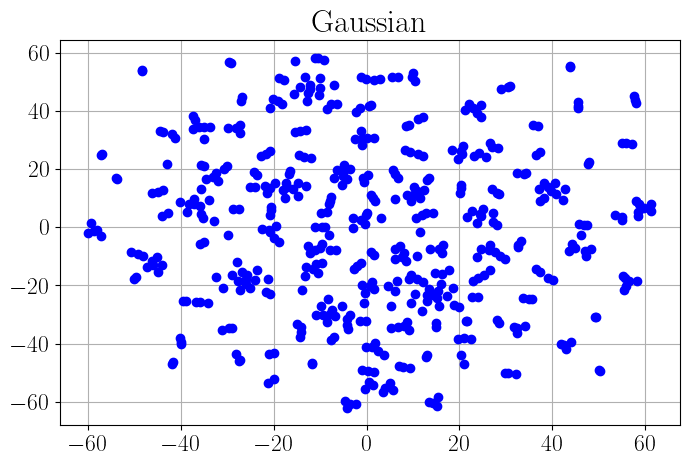

In [166]:
plt.figure(figsize=tsne_size)
X_data = np.transpose(x)
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X_data)
plt.plot(X_embedded[:, 0], X_embedded[:, 1], "o", color="blue")
plt.grid()
plt.xticks(fontsize=fs_ticks_tsne+5)
plt.yticks(fontsize=fs_ticks_tsne+5)
plt.title("Gaussian", fontsize=fs_tsne+3)
plt.savefig("Plots/tsne_gaussian.pdf", bbox_inches='tight')
plt.show()

We define a PCA object, and require that the amount of components kept is able to explain 90% of the variance as illustration:

In [167]:
q = 0.90
pca = PCA(q)
pca.fit(x)
print(f"For {100*q}% explained variance, we keep {pca.n_components} components")

For 90.0% explained variance, we keep 41 components


Plot the cumulative sum of the eigenvalues:

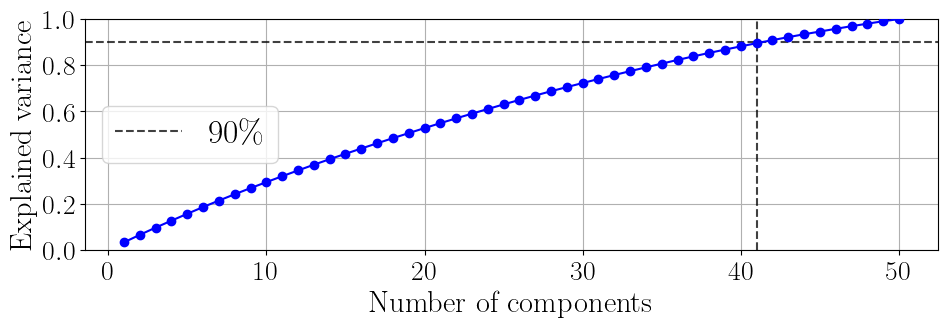

In [168]:
# Plot hyperparams
alph = 0.75
# Plot cumulative sum
plt.plot([i+1 for i in range(len(pca.cumsum))], pca.cumsum, '-o', color="blue", zorder = 100)
# Plot where the ratio was achieved
plt.axhline(pca.q, linestyle="--", color="black", label= r"90\%",alpha=alph)
plt.axvline(pca.n_components, linestyle="--", color="black", alpha=alph)
plt.xlabel("Number of components", fontsize=fs_labels)
plt.ylabel("Explained variance", fontsize=fs_labels)
plt.ylim(0, 1)
plt.legend(fontsize=fs_legend)
plt.grid()
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.savefig(os.path.join(plots_dir, "PCA_gaussian_cumsum.pdf"), bbox_inches='tight')
plt.show()

In [169]:
def rmsd(x, x_hat):
    """Computes RMSD measure between two Numpy arrays

    Args:
        x (np.array): Original data.
        x_hat (np.array): Reconstructed data to be compared against x.

    Returns:
        float: RMSD value, or error/distance between x and x_hat.
    """
    return np.sqrt(np.mean((x-x_hat)**2))

Now we examine the different reduced datasets for different dimensions. 

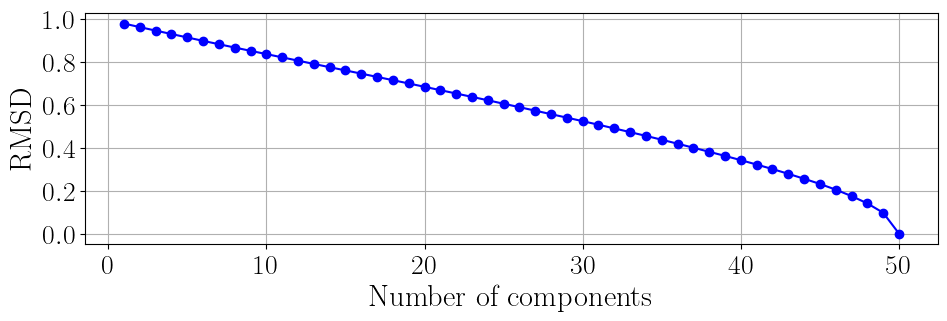

In [170]:
errors = []
for i in range(1, 51):
    # Set number of PCA components
    pca.q = i
    # Fit again
    pca.fit(x)
    # Get reconstructed
    x_hat = pca.inverse_transform(pca.transform(x))
    errors.append(rmsd(x, x_hat))
# Plot cumulative sum
plt.plot([i+1 for i in range(len(errors))], errors, '-o', color="blue")
plt.xlabel("Number of components", fontsize = fs_labels)
plt.ylabel("RMSD", fontsize = fs_labels)
# plt.legend(fontsize = fs_legend)
plt.grid()
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.savefig(os.path.join(plots_dir, "PCA_RMSD_gaussian.pdf"), bbox_inches='tight')
plt.show()

What was the final error?

In [171]:
errors[-1]

1.593201040677711e-14

This is essentially zero, and probably because all the eigenvalues are quite large

In [172]:
min(pca.eigenvals)

0.4699600513098601

## PCA on cholesterol data

In this second application, we consider a PCA analysis performed on cholesterol data that is available in Matlab. The data was loaded into matlab and then saved into a `.mat` file such that it can be postprocessed in Python. We only consider the feature data (called `p` in Matlab).

In [173]:
# Load the .mat files for p and t
p_data = scipy.io.loadmat(os.path.join(data_dir, 'choles_all_p.mat'))['p']
dim = p_data.shape[0]
# t_data = scipy.io.loadmat(os.path.join(data_dir, 'choles_all_t.mat'))['t'] # only use p data

Extra: t-SNE

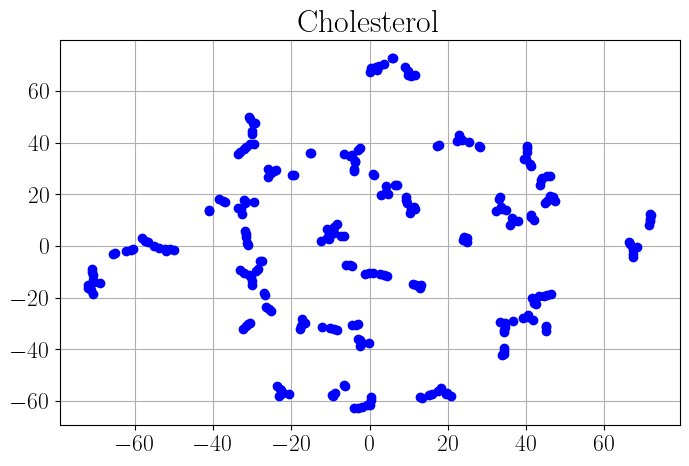

In [174]:
plt.figure(figsize=tsne_size)
X_data = np.transpose(p_data)
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X_data)
plt.plot(X_embedded[:, 0], X_embedded[:, 1], "o", color="blue")
plt.grid()
plt.xticks(fontsize=fs_ticks_tsne+5)
plt.yticks(fontsize=fs_ticks_tsne+5)
plt.title("Cholesterol", fontsize=fs_tsne+3)
plt.savefig("Plots/tsne_cholesterol.pdf", bbox_inches='tight')
plt.show()

We define a PCA object, and require that the amount of components kept is able to explain 99.9% of the variance: we see that we only need 3 out of 21 components to explain this high percentage of the variance. 

In [175]:
q=0.999
pca = PCA(q)
pca.fit(p_data)
print(f"For {100*q}% explained variance, we keep {pca.n_components} components")

For 99.9% explained variance, we keep 3 components


Plot the cumulative sum of the eigenvalues:

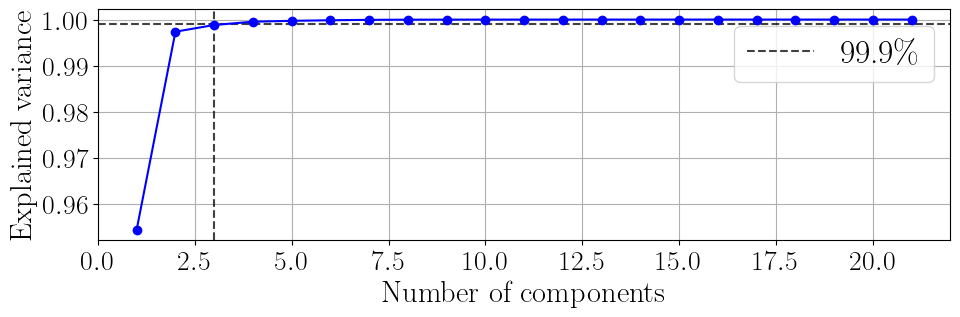

In [176]:
# Plot hyperparams
alph = 0.75
# Plot cumulative sum
plt.plot([i+1 for i in range(len(pca.cumsum))], pca.cumsum, '-o', color="blue", zorder = 100)
# Plot where the ratio was achieved
plt.axhline(pca.q, linestyle="--", color="black", label= f"{100*pca.q}\%",alpha=alph)
plt.axvline(pca.n_components, linestyle="--", color="black", alpha=alph)
plt.xlabel("Number of components", fontsize=fs_labels)
plt.ylabel("Explained variance", fontsize=fs_labels)
# plt.axhline(0, color="black")
# plt.axhline(1, color="black")
# plt.ylim(0.95, 1)
plt.legend(fontsize=fs_legend)
plt.grid()
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.savefig(os.path.join(plots_dir, "PCA_choles_cumsum.pdf"), bbox_inches='tight')
plt.show()

We again compute the RMSD error for increasing number of principal components.

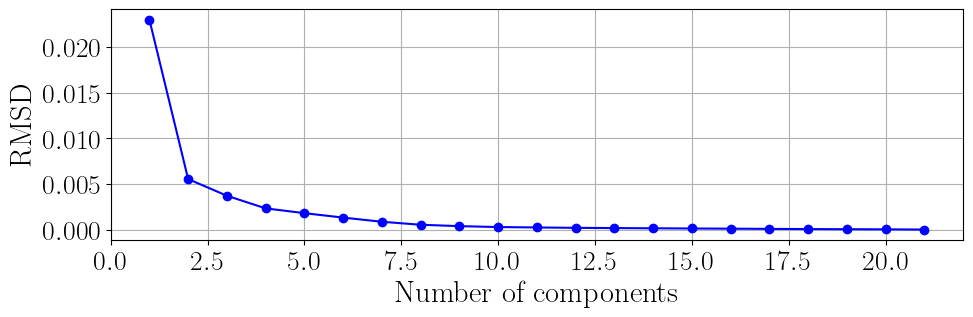

In [177]:
errors = []
for i in range(1, dim+1):
    # Set number of PCA components
    pca.q = i
    # Fit again
    pca.fit(p_data)
    # Get reconstructed
    p_data_hat = pca.inverse_transform(pca.transform(p_data))
    errors.append(rmsd(p_data, p_data_hat))
    
# Plot errors
plt.plot([i+1 for i in range(len(errors))], errors, '-o', color="blue")
plt.xlabel("Number of components", fontsize=fs_labels)
plt.ylabel("RMSD", fontsize=fs_labels)
# plt.yscale('log')
plt.grid()
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.savefig(os.path.join(plots_dir, "PCA_RMSD_choles.pdf"), bbox_inches='tight')
plt.show()

What was the final error?

In [178]:
print(errors[-1])
# print(pca.eigenvals[:-5])

1.533640402661072e-14


There is a clear difference between the random Gaussian data and the highly correlated cholesterol data. In general, highly correlated data tends to exhibit more structure than random data. As a result, PCA on highly correlated data can often result in a more significant reduction in dimensionality compared to PCA on random data. As a result, highly correlated data tends to have a smaller number of principal components that capture most of the variance in the data, while random data tends to require more principal components to capture the same amount of variance.

## PCA on handwritten digits

Our final application of PCA involves a dataset containing handwritten digits, which can be represented as a 256-dimensional vector or can be reshaped into a 16 by 16 image of greyscale pixel values. We rely on an auxiliary function that helps us when plotting the digits as images.

In [179]:
# Make the shape of the images a global constant
THREE_SHAPE = (16, 16)
# Load the threes dataset
threes = np.loadtxt(os.path.join(data_dir, "threes.mat"))
# "Transpose" (swap axes) to get in the same p x N shape
threes_T = np.swapaxes(threes, 0, 1)
dim = 256

Extra: t-SNE

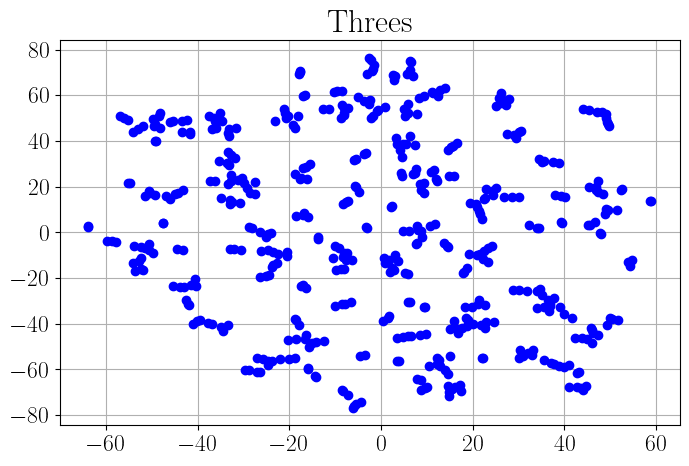

In [180]:
plt.figure(figsize=tsne_size)
X_data = threes
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X_data)
plt.plot(X_embedded[:, 0], X_embedded[:, 1], "o", color="blue")
plt.grid()
plt.xticks(fontsize=fs_ticks_tsne+5)
plt.yticks(fontsize=fs_ticks_tsne+5)
plt.title("Threes", fontsize=fs_tsne+3)
plt.savefig("Plots/tsne_threes.pdf", bbox_inches='tight')
plt.show()

We define an auxiliary function that reshapes the vectors in the correct matrix for plotting them as images, and also rotate the images and rescale their pixel values to make sure that the plotting procedure is able to interpret this matrix as a grid of pixel values.

In [181]:
def to_image(three_vector):
    """Converts a vector of threes to an image: reshape and rotate by 90 degrees"""
    
    img = np.rot90(three_vector.copy().reshape(THREE_SHAPE))
    img = rescale_intensity(img, out_range=(0,1))
    
    return img

To get a feeling of how the dataset looks like, we plot a few examples of "threes":

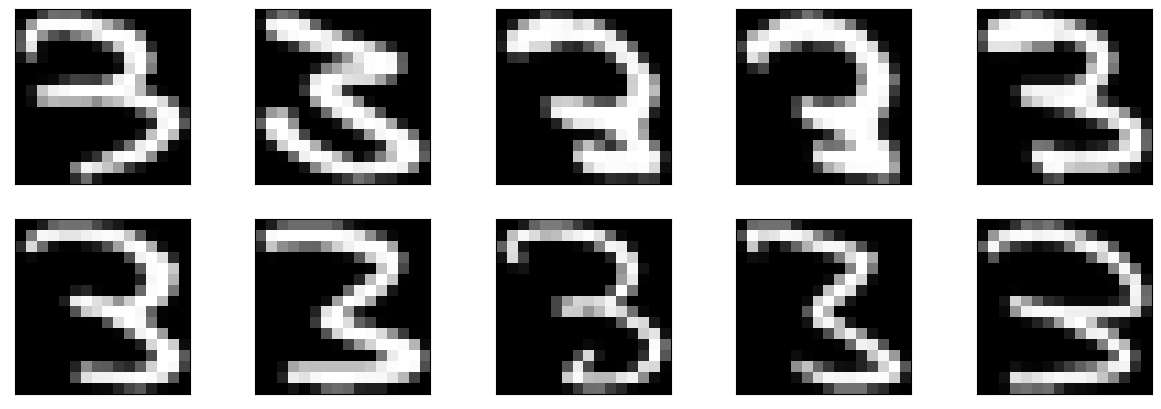

In [182]:
# Create sequence of plots
dat = threes[:10].copy()
n = len(dat)
n_cols = 5
fig, axs = plt.subplots(n//n_cols, n_cols, figsize=(15, 5))

for i, img in enumerate(dat):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(to_image(img), cmap="Greys_r")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Now, we perform PCA on the dataset. *Note:* we have to transpose the dataset in order to get it to the $p\times N$ shape! This matrix is stored in `threes_T` which took care of this swap earlier on.

In [183]:
pca = PCA(0.90)
pca.fit(threes_T.copy())

We plot the mean vector stored by PCA as an image, hence this is the "mean three":

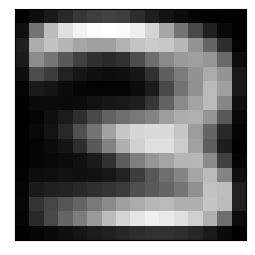

In [184]:
mean_three = to_image(pca.mean)
plt.imshow(mean_three, cmap="Greys_r")
plt.xticks([])
plt.yticks([])
# plt.title("Mean three")
plt.savefig(os.path.join(plots_dir, "PCA_mean_three.pdf"), bbox_inches = "tight")
plt.show()

We plot the eigenvalues:

In [185]:
# plt.plot([i+1 for i in range(len(pca.eigenvals))], pca.eigenvals, "-o", color="blue")
# plt.grid()
# plt.show()

But perhaps it is more informative to plot the cumulative sum of explained variance ratio:

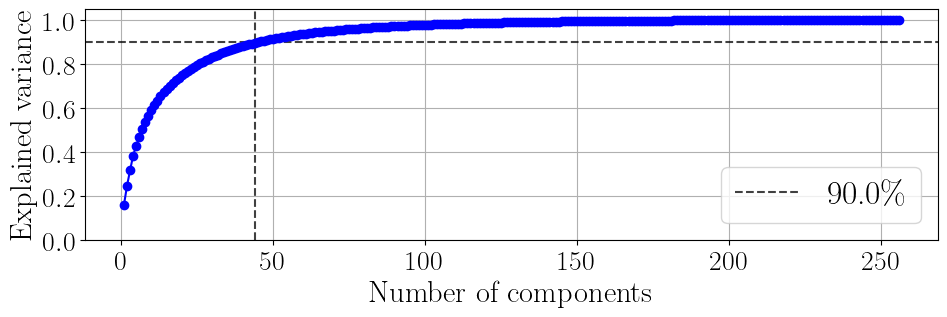

In [186]:
# Plot hyperparams
alph = 0.75
# Plot cumulative sum
plt.plot([i+1 for i in range(len(pca.cumsum))], pca.cumsum, '-o', color="blue", zorder = 100)
# Plot where the ratio was achieved
plt.axhline(pca.q, linestyle="--", color="black", label= f"{100*pca.q}\%",alpha=alph)
plt.axvline(pca.n_components, linestyle="--", color="black", alpha=alph)
plt.xlabel("Number of components", fontsize=fs_labels)
plt.ylabel("Explained variance", fontsize=fs_labels)
# plt.axhline(0, color="black")
# plt.axhline(1, color="black")
plt.ylim(0, 1.05)
plt.legend(fontsize=fs_legend)
plt.grid()
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.savefig(os.path.join(plots_dir, "PCA_threes_cumsum.pdf"), bbox_inches='tight')
plt.show()

We now will look at various reconstructions of a few example threes by using 1 to 4 princial components. We chose three examples based on them having slightly visual appearances in order to have a better look a the reconstruction methods:

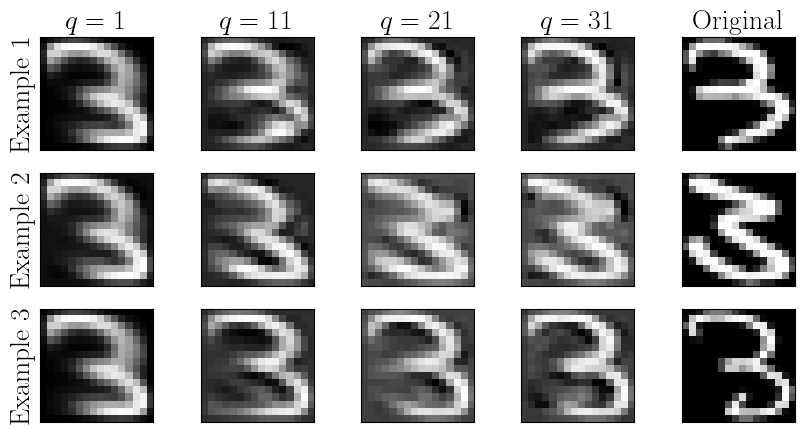

In [187]:
sample_ind = np.array([0, 1, 7])
sample = threes[sample_ind].copy()

# Create sequence of plots
jump = 10  # increment in number of PCs used, default 1
n_rows = len(sample)
n_cols = 5 # 4 components + original
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5))

for i in range(n_rows*n_cols):
    # Get index
    row, col = i//n_cols, i%n_cols
    ax = axs[row, col]
    # Row determines which data we are considering, reshape into a single sample
    vec = sample[row]
    x = vec.copy()
    # Col determines number of components or OG -- create img
    if col == n_cols - 1:
        img = to_image(x)
        if row == 0:
            ax.set_title("Original", fontsize=fs)
    else:
        # Do another PCA fit with certain number of components
        q = int(jump*col+1)
        pca = PCA(q=q)
        pca.fit(threes_T)
        reconstructed = pca.inverse_transform(pca.transform(x.reshape(-1,1)))
        img = to_image(reconstructed)
        if row == 0:
            ax.set_title(r"$q = {}$".format(q), fontsize=fs)
    
    # Plot image and remove ticks
    ax.imshow(img, cmap="Greys_r")
    ax.set_xticks([])
    ax.set_yticks([])
    # Set title etc
    if col == 0:
        ax.set_ylabel(f"Example {row+1}", fontsize=fs)

plt.savefig(os.path.join(plots_dir, "PCA_reconstructing_threes.pdf"), bbox_inches="tight")
plt.show()

We loop over the whole dataset and consider the reconstruction error for varying number of components

In [188]:
errors = []
for i in range(1, dim):
    # Set number of PCA components
    pca = PCA(q=i)
    # Fit again
    pca.fit(threes.T)
    # Get reconstructed
    threes_hat = pca.inverse_transform(pca.transform(threes_T))
    errors.append(rmsd(threes_T, threes_hat))


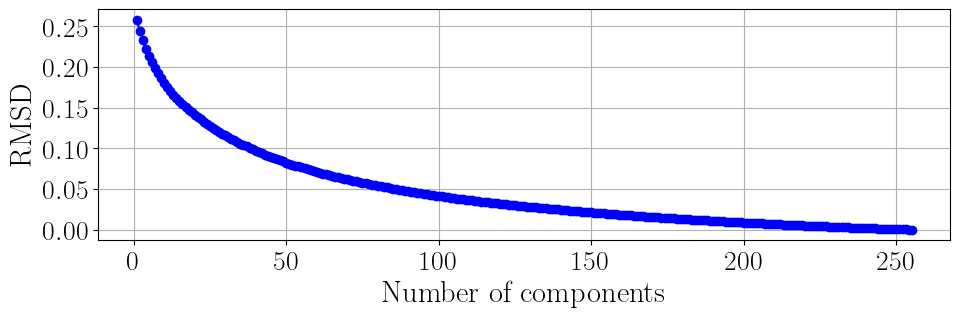

In [193]:
# Plot cumulative sum
plt.plot([i+1 for i in range(len(errors))], errors, '-o', color="blue")
plt.xlabel("Number of components", fontsize=fs_labels)
plt.ylabel("RMSD", fontsize=fs_labels)
plt.grid()
# plt.yscale('log')
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.savefig(os.path.join(plots_dir, "PCA_RMSD_digits.pdf"), bbox_inches='tight')
plt.show()

What is the final reconstruction error?=

In [190]:
errors[-1]

1.4770323517907782e-05

The final reconstruction error is not exactly zero: why? Probably because the smallest eigenvalues are so small!

In [191]:
pca.eigenvals[-20:]

array([1.82794034e-04, 1.69869211e-04, 1.42386896e-04, 1.24468190e-04,
       1.08153382e-04, 1.03536113e-04, 1.00084159e-04, 9.58418700e-05,
       8.17830760e-05, 6.94709239e-05, 5.21968668e-05, 5.10669925e-05,
       4.17164727e-05, 3.73459447e-05, 2.89281960e-05, 1.67956192e-05,
       9.62325818e-06, 6.38550743e-06, 5.08653332e-07, 5.59615120e-08])

# Stacked autoencoders

In [240]:
df = pd.read_csv("Files/SAE_results.csv")
df.head(5)

,Hidden,Layers,Acc before,Acc after
0,100,1,0.9866,0.9908
1,100,2,0.9100,0.9920
2,100,3,0.6808,0.9940
3,100,1,0.9838,0.9896
4,100,2,0.9150,0.9914


What are the standard deviations?

In [255]:
df = pd.read_csv("Files/SAE_results.csv").groupby(["Layers", "Hidden"]).std()
df

Acc before  Acc after
Layers Hidden                       
1      100       0.001474   0.000643
       200       0.001474   0.001137
2      100       0.008626   0.000416
       200       0.002272   0.001553
3      100       0.009488   0.001528
       200       0.004670   0.001172
4      200       0.001501   0.000808

Create nice dataframe for exportation and plotting:

In [ ]:
def create_discounted_vector(h, N):
    """
    Auxiliary function, returns a vector like [h, h/2, h/4, ...], length decided by N.
    Returned as tuple and int type, for hashing and nice printing in the LaTeX table.
    """
    vector = np.array([h/(2**i) for i in range(N)]).astype('int')
    return tuple(vector)

In [259]:
df = pd.read_csv("Files/SAE_results.csv")#.groupby("Layers").mean()
sort_key = "Acc before"

acc_before = df["Acc before"].values
acc_after = df["Acc after"].values
# Convert the h and N to hidden sizes list, then drop em
hidden_sizes = []
for i in range(len(df)):
    hidden_sizes.append(create_discounted_vector(df["Hidden"][i], df["Layers"][i]))
df["Hidden sizes"] = hidden_sizes
df["Acc before"] = 100 * df["Acc before"]
df["Acc after"]  = 100 * df["Acc after"]
df.drop(["Hidden", "Layers"], axis=1, inplace=True)
# Add improvements made by finetuning
df["Improvements"] = df["Acc after"] - df["Acc before"]
df = df.groupby(["Hidden sizes"]).mean()
df = df.sort_values(by = [sort_key], ascending=False)
df

,Acc before,Acc after,Improvements
Hidden sizes,,,
"(200, 100, 50, 25)",99.493333,99.653333,0.160000
"(200,)",99.286667,99.446667,0.160000
"(100,)",98.493333,99.006667,0.513333
"(200, 100)",98.380000,98.713333,0.333333
"(100, 50)",90.773333,99.153333,8.380000
"(200, 100, 50)",89.053333,99.353333,10.300000
"(100, 50, 25)",67.593333,99.266667,31.673333


In [258]:
print(df["Improvements"].values)

[ 0.16        0.16       10.3        31.67333333  8.38        0.51333333
  0.33333333]


In [250]:
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Acc before &  Acc after \\
Hidden sizes        &             &            \\
\midrule
(400, 200, 100, 50) &   99.493333 &  99.653333 \\
(400,)              &   99.286667 &  99.446667 \\
(400, 200, 100)     &   89.053333 &  99.353333 \\
(200, 100, 50)      &   67.593333 &  99.266667 \\
(200, 100)          &   90.773333 &  99.153333 \\
(200,)              &   98.493333 &  99.006667 \\
(400, 200)          &   98.380000 &  98.713333 \\
\bottomrule
\end{tabular}



C:\Users\thibe\AppData\Local\Temp\ipykernel_25332\2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


Figure: deprecated, not so nice

In [213]:
# plt.figure(figsize=(11, 2))
# xt = [i+1 for i in range(len(acc_before))]
# plt.plot(xt, acc_before, "--o", color="blue", label = "Original")
# plt.plot(xt, acc_after, "-o", color="blue", label = "Finetuned")
# plt.legend(fontsize=14, loc="lower left")
# plt.xticks(xt, fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlabel("Number of layers", fontsize=14)
# plt.ylabel("Accuracy", fontsize=14)

# plt.grid()
# plt.savefig("Plots/SAE.pdf")
# plt.show()